# Deconfounding

This notebook provides a quick overview of the rationale behind the use of confounds within `genbed`.

It is principally a discussion about demeaning covariates, which is something that Jeanette Mumford has covered much more eloquently already: <http://mumford.fmripower.org/mean_centering/>. However, the difference here is that we are not interested in the effect sizes per se; rather, we regress out the confounds 'aggressively' (i.e. without any other terms in the linear model to capture e.g. group effects).

See Griffanti et al., "ICA-based artefact removal and accelerated fMRI acquisition for improved resting state network imaging", NeuroImage, 2014 (DOI:&nbsp;[10.1016/j.neuroimage.2014.03.034](https://doi.org/10.1016/j.neuroimage.2014.03.034)) for a discussion of 'aggressive' versus 'soft' confound regression.

-----

### Preamble

In [1]:
# Make sure we are able to load `genbed` itself

#import os
#print(os.getcwd())

import sys
sys.path.insert(0, '../')

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np

In [3]:
# Set up figure plotting parameters
%matplotlib inline
# https://stackoverflow.com/a/50812446
mpl.rcParams['figure.figsize'] = (8.0, 6.0)
mpl.rcParams['figure.dpi'] = 100.0

-----

### Demeaning: simple example

Here, we simply aim to show why demeaning is desirable. In this hypothetical example, we want to use maximum heart rate as a predictor in a downstream classification analysis, but we want to see if there is a relationship that holds independent of age. The relationship between max heart rate and age is, to a reasonable first approximation, `max_hr ≈ 220 - age`. However, as illustrated below, if we simply regress out age directly, this gives unexpected results.

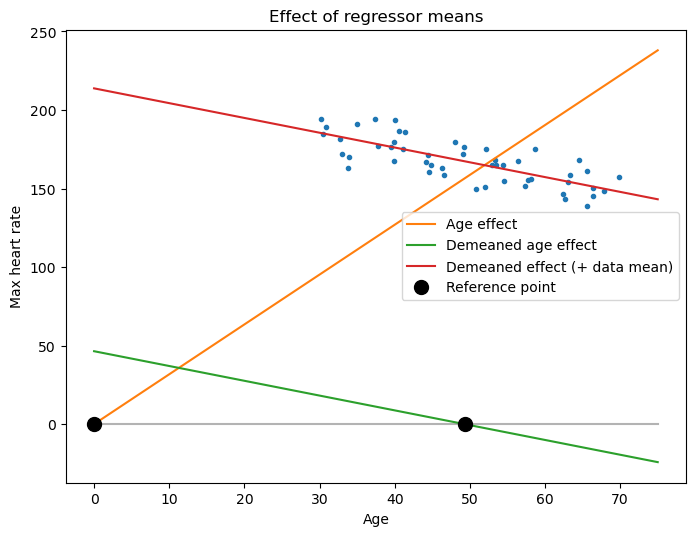

In [4]:
# Generate data
n_subjects = 50
age = np.random.uniform(low=30.0, high=70.0, size=[n_subjects, 1])
max_hr = (220.0 - age) + np.random.normal(loc=0.0, scale=10.0, size=[n_subjects, 1])

# Plot raw data
plt.figure(); plt.title("Effect of regressor means")
plt.plot([0.0, 75.0], [0.0, 0.0], color=[0.7]*3)
plt.plot(age, max_hr, '.')
plt.xlabel('Age'); plt.ylabel('Max heart rate')

# Different modelling strategies
x = np.linspace(0.0, 75.0, 100)[:, np.newaxis]
# Raw age
beta = np.linalg.pinv(age) @ max_hr
plt.plot(x, x @ beta, label="Age effect")
# Demeaned age
beta = np.linalg.pinv(age - age.mean()) @ max_hr
plt.plot(x, (x - age.mean()) @ beta, label="Demeaned age effect")
plt.plot(
    x, (x - age.mean()) @ beta + max_hr.mean(),
    label="Demeaned effect (+ data mean)"
)
# Add different zero points
plt.plot([0.0, age.mean()], [0.0, 0.0], 'ko', ms=10.0, label="Reference point")
plt.legend()

Clearly, simply modelling age directly does not do what we want. If we tried to subtract the naïvely modelled confound (i.e. the orange line) from the original data we would be in a worse position than where we started! In essence, we also need to model the intercept to properly capture the effect of age.

In practice, there are several ways we can do this. The obvious ones are:
 1. Demean the confound regressors themselves. As the predicted effect is then also zero mean, this leaves the data mean unchanged.
 2. Add a mean regressor as well, and remove this as a confound. This would remove the mean from the data too.
 3. Add a mean regressor to the model, but do not remove it's contribution to the data (non-aggressive removal). This would set the data mean to be equivalent to the expected max heart rate at age zero.

Note that other approaches, like demeaning the data first, are equivalent to one of the above.

The difference between these approaches is therefore how we model the mean itself, and they imply different 'reference points'. For these linear models, we can think of where the regressor is zero as the reference: by definition, a data point here would be unchanged by the removal of the confound. If we demean the age regressor then this happens at the mean age across the cohort. If we do not demean, this is at age zero. In approach 3, even though we correctly remove the confound, we then have to interpret the deconfounded max heart rate as being our prediction for what we would have observed if all subjects had been measured at birth! While this involves a large extrapolation and is unlikely to be what we want, it is technically correct from the point of view of our original equation (`max_hr ≈ 220 - age`).

From the point of view of a downstream classifier however, this is almost always unimportant (we typically normalise the input data anyway). Therefore the question is essentially an aesthetic one. We choose to demean the confounds as this gives, in some sense, the least surprising result. For example, if we were to plot or report the max heart rates after deconfounding, then 170±10 bpm is the least surprising outcome for a cohort of age 50±10 years. We illustrate this below.

In [5]:
cleaned_data = {}
cleaned_data["Raw data"] = max_hr

# 1: Demeaned regressors
betas = np.linalg.pinv(age - age.mean()) @ max_hr
cleaned_data["Approach 1"] = max_hr - ((age - age.mean()) @ betas)

# Include mean regressor
confounds = np.concatenate([age, np.ones_like(age)], axis=1)
betas = np.linalg.pinv(confounds) @ max_hr
# 2: Remove all confounds
cleaned_data["Approach 2"] = max_hr - (confounds @ betas)
# 2: Do not remove mean confound
cleaned_data["Approach 3"] = max_hr - (confounds[:, :-1] @ betas[:-1, :])

for method, data in cleaned_data.items():
    print(method)
    print(
        "Mean max heart rate across subjects: {:.1f}±{:.1f}"
        .format(np.mean(data), np.std(data))
    )
    print()

Raw data
Mean max heart rate across subjects: 167.4±14.1

Approach 1
Mean max heart rate across subjects: 167.4±9.1

Approach 2
Mean max heart rate across subjects: 0.0±9.1

Approach 3
Mean max heart rate across subjects: 213.8±9.1



In [6]:
# plt.plot(age, max_hr, '.')
# plt.xlabel('Age'); plt.ylabel('Max heart rate')
# plt.title("Raw data")

# plt.plot(age, max_hr - age @ (np.linalg.pinv(age) @ max_hr), '+')
# plt.xlabel('Age'); plt.ylabel('Max heart rate')
# plt.title("Raw data")

# plt.plot(age, max_hr - (age - np.mean(age)) @ (np.linalg.pinv(age - np.mean(age)) @ max_hr), '*')
# plt.xlabel('Age'); plt.ylabel('Max heart rate')
# plt.title("Raw data")

# confounds = np.concatenate([age, np.ones_like(age)], axis=1)
# plt.plot(age, max_hr - age @ (np.linalg.pinv(confounds) @ max_hr)[[0],:], 'x')
# plt.xlabel('Age'); plt.ylabel('Max heart rate')
# plt.title("Raw data")

-----

### Demeaning: multiple groups

The above example is perhaps too simple to draw any firm conclusions. In the below, we use a more involved situation.

We simulate data from a group of subjects, some of whom are taking medication. What we have here is a strong effect of drug, but one that saturates at higher doses. We can therefore model this with two regressors: a binary `drug` indicator, and a continuous `dose` regressor. Given that there is a group-specific substructure to the data, does the default approach of demeaning across all subjects break in this instance?

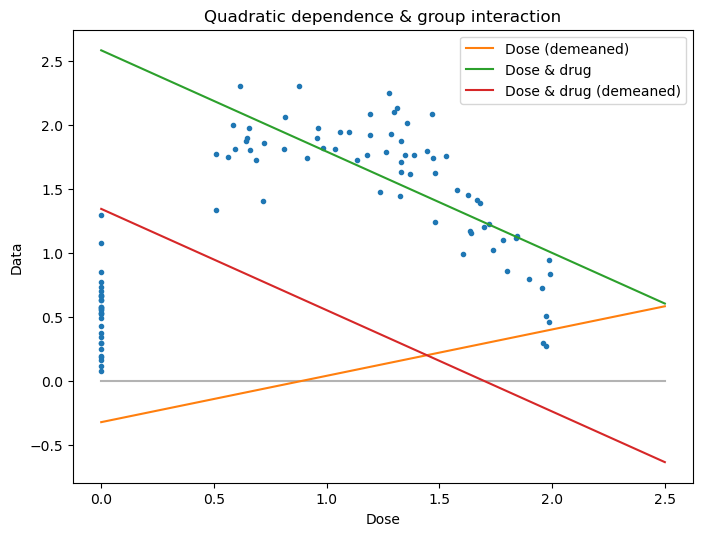

In [7]:
# Generate data
n_subjects = 100
effect = 0.25 * np.random.randn(n_subjects, 1) + 0.5
drug = (np.random.rand(n_subjects, 1) > 0.33)
dose = drug * (1.5 * np.random.rand(n_subjects, 1) + 0.5)
data = effect - 1.5 * ((dose - 1.0)**2 - 1.0)
#data = data + 0.1 * np.random.randn(n_subjects, 1)

predicted_effects = {}
predicted_effects["Ground truth"] = effect

# Plot raw data
plt.figure(); plt.title("Quadratic dependence & group interaction")
plt.plot([0.0, 2.5], [0.0, 0.0], color=[0.7]*3)
plt.plot(dose, data, '.')
plt.xlabel('Dose'); plt.ylabel('Data')

# Different cleanup strategies
x = np.linspace(0.0, 2.5, 100)[:, np.newaxis]

# Regress out raw dose
# beta = np.linalg.pinv(dose) @ data
# plt.plot(x, x @ beta, label="Dose")

# Regression for demeaned dose
beta = np.linalg.pinv(dose - dose.mean()) @ data
plt.plot(x, (x - dose.mean()) @ beta, label="Dose (demeaned)")

# Regression for dose, in the drug group
confounds = np.concatenate([drug, dose], axis=-1)
betas = np.linalg.pinv(confounds) @ data
plt.plot(x, x * betas[1] + betas[0], label="Dose & drug")
predicted_effects["Drug & dose"] = data - (confounds @ betas)

# Regression for dose, in the drug group (both demeaned)
betas = np.linalg.pinv(confounds - confounds.mean(axis=0)) @ data
plt.plot(
    x, (x - dose.mean()) * betas[1] + (1.0 - drug.mean()) * betas[0],
    label="Dose & drug (demeaned)"
)
predicted_effects["Drug & dose (demeaned)"] = data - ((confounds - confounds.mean(axis=0)) @ betas)

plt.legend()

#ref = dose.mean() - (betas[0] * (1.0 - drug.mean())) / betas[1]
#plt.plot(x, (x - ref) * betas[1], label="Dose & drug (demeaned)")
#plt.plot(x, (x - ref) * betas[1], label="Dose & drug (demeaned)")
#X = np.concatenate([np.ones([100,1]), x], axis=-1)
#plt.plot(x, (X - confounds.mean(axis=0)) @ betas, label="Dose & drug (demeaned)

# plt.plot([0.0, dose.mean(), ref], [0.0, 0.0, 0.0],
#          'ko', ms=10.0, label="Reference point")
#plt.legend(); plt.ylim(bottom=-3.0)

# Regression including a whole group mean
confounds = np.concatenate([drug, dose, np.ones_like(dose)], axis=-1)
betas = np.linalg.pinv(confounds) @ data
predicted_effects["Drug, dose & mean"] = data - (confounds[:, :-1] @ betas[:-1, :])

If we look at the modelled effects above, then we see that, in a similar manner to the first example, simply modelling dose by itself is not sufficient (even if we demean). This is because we ignore the difference in means between the groups.

However, if we include both a regressor for drug group and a dose regressor, then the models seem to be appropriate both with and without demeaning. In this instance, however, it seems intuitive to leave the means in the confound regressors. If we do this, then both the drug and dose regressors are zero in the medication-free group. If we want to remove the effect of drug, surely the simplest approach is to leave the data from the drug-free group untouched?

However, as we show below, this introduces a subtle bias. In essence, the drug regressor removes the mean effect from the data of the drug group. However, if we have a non-zero effect in the non-drug group, then the groups will have different means after deconfounding. What we are trying to do when we deconfound is remove the *difference between* the groups, and to do this our model needs to acknowledge the drug-free group too.

We illustrate this below:

# Raw data
Mean: +1.24

# Ground truth
Mean effect (drug group):    +0.48
Mean effect (no-drug group): +0.53

# Drug & dose
Mean effect (drug group):    -0.00
Mean effect (no-drug group): +0.53

# Drug & dose (demeaned)
Mean effect (drug group):    +1.24
Mean effect (no-drug group): +1.24

# Drug, dose & mean
Mean effect (drug group):    +0.53
Mean effect (no-drug group): +0.53



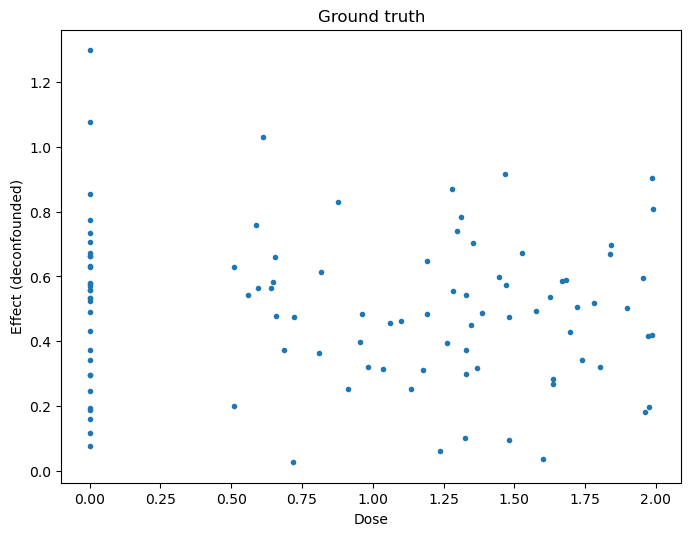

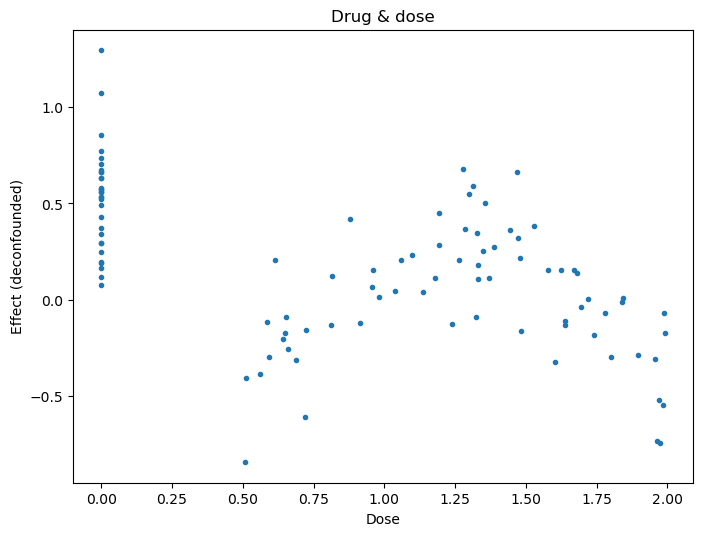

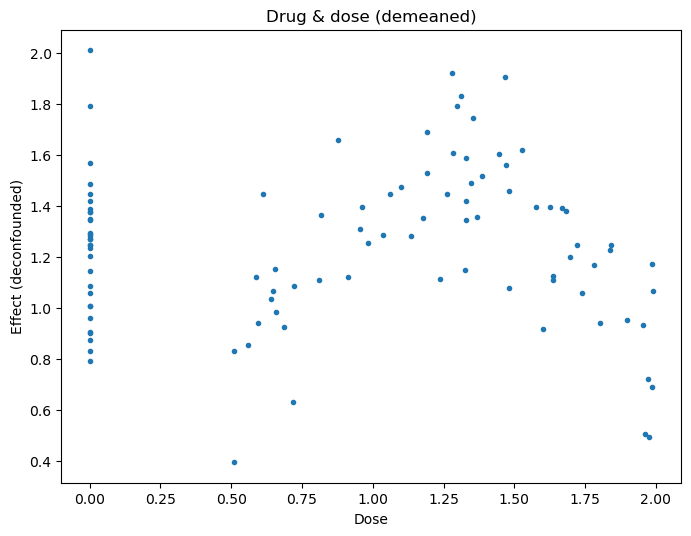

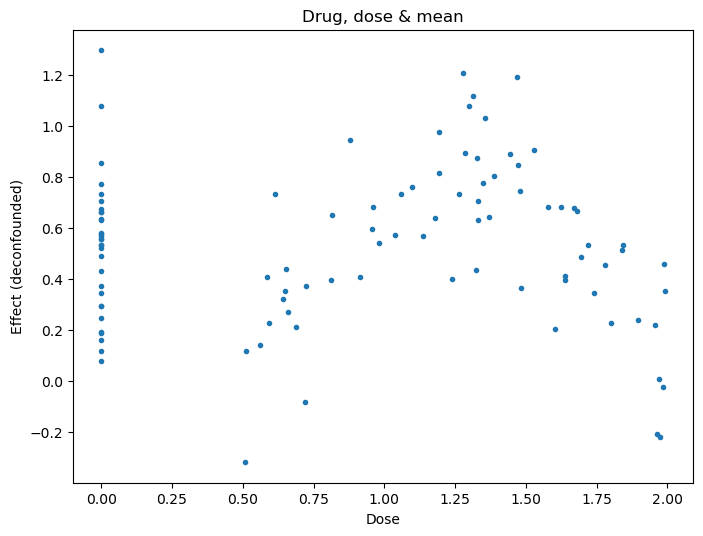

In [8]:
print("# Raw data")
print("Mean: {:+.2f}".format(np.mean(data)))
print()

for method, predicted_effect in predicted_effects.items():
    plt.figure()
    plt.plot(dose, predicted_effect, '.')
    plt.xlabel('Dose'); plt.ylabel('Effect (deconfounded)')
    plt.title(method)
    
    print("# {}".format(method))
    print(
        "Mean effect (drug group):    {:+.2f}"
        .format(np.mean(predicted_effect[drug]))
    )
    print(
        "Mean effect (no-drug group): {:+.2f}"
        .format(np.mean(predicted_effect[~drug]))
    )
    print()

In the above plots, we show the effects after deconfounding. As explained, drug & dose leave a group difference if we do not demean. As in the first example then, we have a choice between either demeaning the confounds, or adding a mean regressor to the model. While we cannot remove the nonlinear effect, these both remove the group difference and linear trends appropriately.

In this instance, the demeaned approach leaves the mean deconfounded effect at the mean of the data. Adding the extra regressor to the design and removing non-aggressively adjusts the mean of the drug group to match the mean of the non-drug group. In this instance then -- and unlike the heart rate example -- this is probably the more intuitive behaviour. If we were to report the effect itself after deconfounding, we would need to be clear that this represents what we would observe at a hypothetical 'average' medication regime.

-----

### Summary

What we have demonstrated here is that care needs to be taken when deconfounding, even in simple situations. In `genbed`, the default approach is to demean confounds, as this is (1) often the least surprising approach for simple models and (2) straightforward to implement. However, it is still important to understand how to interpret the data after deconfounding.